In [31]:
# -------------------------------
#Importing Dependencies
# -------------------------------
import csv
import os
# Organisation Libraries 
import pandas as pd
import numpy as np

# SQL Libraries
from sqlalchemy import create_engine
import psycopg2
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

import time
from getpass import getpass

# ML Libraryies
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import hvplot.pandas
import plotly.express as px

In [32]:
# Using psycopg2 to pull from the NBA_Analysis DB
password = getpass()
cn = psycopg2.connect(host = "127.0.0.1", port = "5432", database = "NBA_Analysis", user = "postgres", password = password)
cur = cn.cursor()


#Querying test Data
cur.execute("""
SELECT main.id, main.player, main.u_player, misc.stl, misc.drb, misc.blk
FROM main  
LEFT JOIN misc
ON main.id = misc.id;
""")
test_results = cur.fetchall()

# Getting the column headers for test Table
cur.execute("""
SELECT main.id, main.player, main.u_player, misc.stl, misc.drb, misc.blk
FROM main  
LEFT JOIN misc
ON main.id = misc.id LIMIT 0;
""")
test_colnames = [desc[0] for desc in cur.description]

#NEW DATA ------------------------------------------s
# Over all player query
cur.execute("""
SELECT main.id, main.player, main.u_player, misc.vorp, misc.per, misc.bpm
FROM main  
LEFT JOIN misc
ON main.id = misc.id;
""")
ovr_results = cur.fetchall()

# Getting the column headers for test Table
cur.execute("""
SELECT main.id, main.player, main.u_player, misc.vorp, misc.per, misc.bpm
FROM main  
LEFT JOIN misc
ON main.id = misc.id LIMIT 0;
""")
ovr_colnames = [desc[0] for desc in cur.description]

#NEW DATA ------------------------------------------
# Over all player query
cur.execute("""
SELECT main.id, main.player, main.u_player, misc.vorp, misc.per, misc.bpm
FROM main  
LEFT JOIN misc
ON main.id = misc.id;
""")
ovr_results = cur.fetchall()

# Getting the column headers for test Table
cur.execute("""
SELECT main.id, main.player, main.u_player, misc.vorp, misc.per, misc.bpm
FROM main  
LEFT JOIN misc
ON main.id = misc.id LIMIT 0;
""")
ovr_colnames = [desc[0] for desc in cur.description]




 ········


In [33]:
# Assigning SQL data to df's
test_df = pd.DataFrame(test_results)
test_df.columns = test_colnames
test_df.head()

#overall df
ovr_df = pd.DataFrame(ovr_results)
ovr_df.columns = ovr_colnames
ovr_df.head()

,id,player,u_player,vorp,per,bpm
0,1,Álex Abrines,Álex Abrines 2016-17,0.1,10.1,-1.6
1,2,Quincy Acy,Quincy Acy 2016-17,0.0,11.8,-2.1
2,3,Steven Adams,Steven Adams 2016-17,1.1,16.5,-0.2
3,4,Arron Afflalo,Arron Afflalo 2016-17,-0.7,8.9,-3.6
4,5,Alexis Ajinça,Alexis Ajinça 2016-17,-0.2,12.9,-3.3


In [36]:
# Creating test
stl = test_df.groupby("player").mean()['stl']
drb = test_df.groupby("player").mean()['drb']
blk = test_df.groupby("player").mean()['blk']


#grouping players across seasons
grouped_test_df = pd.DataFrame({
    "steals": stl,
    "def_reb": drb,
    "blocks": blk
})

#creating ovr_ml_df
vorp = ovr_df.groupby("player").mean()['vorp']
per = ovr_df.groupby("player").mean()['per']
bpm = ovr_df.groupby("player").mean()['bpm']


#grouping players across seasons
ovr_ml_df = pd.DataFrame({
    "vorp": vorp,
    "per": per,
    "bpm": bpm
})

#it looks like we have 69 duplictes, i looked through the list here and 
# it seems liek they are all scrubs. I vote for dropping the duplicates.
dict(grouped_test_df.duplicated().sort_values(ascending = False).head(69))
dict(ovr_ml_df.duplicated().sort_values(ascending = False).head(69))

cleaned_test_df = grouped_test_df.drop_duplicates()
cleaned_ovr_df = ovr_ml_df.drop_duplicates()



In [37]:
# Overall player K means
inertia = []
k = list(range(1, 11))
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(cleaned_ovr_df)
    inertia.append(km.inertia_)

elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", title="Elbow Curve", xticks=k)

:Curve   [k]   (inertia)

In [41]:
def get_clusters(k, data):
    # Create a copy of the DataFrame
    data = data.copy()

    # Initialize the K-Means model
    model = KMeans(n_clusters=k, random_state=0)

    # Fit the model
    model.fit(data)

    # Predict clusters
    predictions = model.predict(data)

    # Create return DataFrame with predicted clusters
    data["class"] = model.labels_

    return data

In [42]:
ovr_three_df = get_clusters(3, cleaned_ovr_df)
ovr_three_df

,vorp,per,bpm,class
player,,,,
A.J. Hammons,-0.200000,8.400000,-6.600000e+00,2
Aaron Brooks,-0.250000,9.650000,-3.750000e+00,2
Aaron Gordon,1.020000,15.140000,-1.665335e-17,1
Aaron Harrison,-0.150000,1.450000,-9.650000e+00,0
Aaron Holiday,-0.133333,10.900000,-2.466667e+00,2
...,...,...,...,...
Zion Williamson,2.350000,25.600000,3.950000e+00,1
Zylan Cheatham,-0.100000,6.700000,-7.200000e+00,2
Álex Abrines,0.000000,8.466667,-2.133333e+00,2


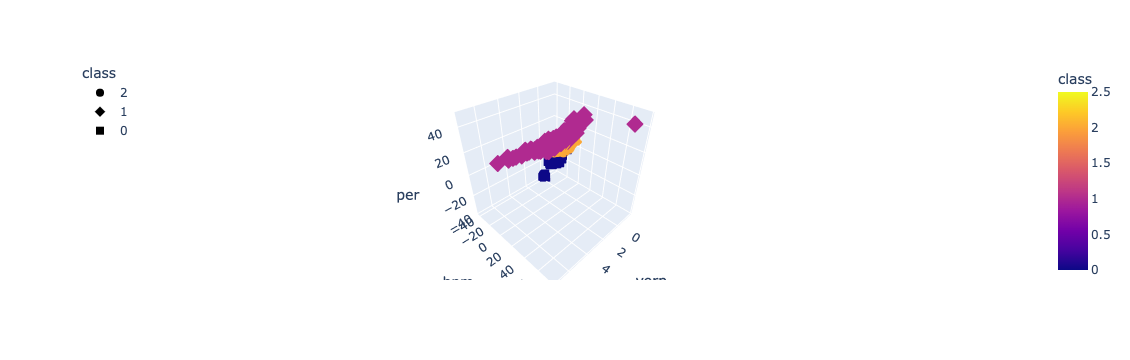

In [49]:
# Plotting the 3D-Scatter with x="Annual Income", y="Spending Score (1-100)" and z="Age"
fig = px.scatter_3d(
    ovr_three_df,
    x="vorp",
    y="bpm",
    z="per",
    color="class",
    symbol="class",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()